# 1. Business Problem
The ojective of this project is to predict whether a client of the company **Home Credit** will default a loan. For that I will use the dataset([available here](https://www.kaggle.com/competitions/home-credit-default-risk/data)) provided for a kaggle competition. This challenge is crucial for Home Credit, a financial institution aiming to provide loans to clients with limited credit history or access to traditional banking services. By leveraging various data sources, including a client's financial history, previous applications, and bureau data, the goal is to develop predictive models that assist in assessing creditworthiness and mitigating default risk. Ultimately, the success of this project directly impacts Home Credit's ability to make informed lending decisions, manage risk effectively, and improve financial inclusion for underserved populations.

**The project objectives include:**

1. Developing predictive models to assess the creditworthiness of clients.
2. Mitigating default risk by accurately identifying clients likely to default on loans.
3. Improving Home Credit's ability to make informed lending decisions.

**The benefits of the project include:**

1. Enhancing Home Credit's risk management practices by leveraging predictive analytics.
2. Improving financial inclusion by extending loans to underserved populations with limited credit history.
3. Enhancing the overall efficiency and effectiveness of Home Credit's lending operations.

**Approach:**

The project employs the ROC-AUC metric for model evaluation, ensuring robust performance assessment across various thresholds. Predicted probabilities are utilized to prioritize efforts and resources on clients with the highest risk of default. This probability ordering approach enables Home Credit to make informed lending decisions while effectively managing default risk.

----

# 2. Understanding the data

For this project we have multiple tables and columns, let's first try to understand the tables and columns.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns


%cd .. 
from utils.plots import plot_numerical_distribution, plot_boxplots,plot_categorical_variables
from utils.utils import print_description, quantify_chi2_target

import warnings
warnings.filterwarnings('ignore')

pos_color = '#f54900'
neg_color = '#0a664f'

/home/silveira/Documents/portifolio/credit_risk_prediction


In [2]:
df_description = pd.read_csv('data/tables/HomeCredit_columns_description.csv')
df_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [4]:
df_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [99]:
df_description.Special.unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized', 'hashed', 'recoded', 'grouped'],
      dtype=object)


---

### Dataset Overview

1. **application_{train|test}.csv**
   - Description: This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.

2. **bureau.csv**
   - Description: All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as the number of credits the client had in Credit Bureau before the application date.

3. **bureau_balance.csv**
   - Description: Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e., the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

4. **POS_CASH_balance.csv**
   - Description: Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e., the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

5. **credit_card_balance.csv**
   - Description: Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e., the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

6. **previous_application.csv**
   - Description: All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

7. **installments_payments.csv**
   - Description: Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

8. **HomeCredit_columns_description.csv**
   - Description: This file contains descriptions for the columns in the various data files.

---

![Alt text](../images/erd.png)


In [6]:
df_description[df_description['Table'] == 'bureau.csv'].head()

,index,Table,Row,Description,Special
122,125,bureau.csv,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
123,126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...,hashed
124,127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
125,128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,129,bureau.csv,DAYS_CREDIT,How many days before current application did c...,time only relative to the application


This table 'HomeCredit_columns_description.csv' describes the columns of all tables. We may use it to understand better the columns and maybe to create new features

# 3. Exploratory Data Analysis

To kick off the analysis, I'll focus on exploring the features within the 'application_train' table. This initial step allows us to gain insights into the dataset's structure, distribution, and relationships before delving into the creation of new features through the exploration of other tables.

In [3]:
df_application_train = pd.read_csv('data/tables/application_train.csv')
print(df_application_train.shape)
df_application_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
missing_values = df_application_train.isnull().sum()
missing_values[missing_values>0]

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64

In [9]:
col_type_counts = df_application_train.dtypes.value_counts()
print(col_type_counts)

float64    65
int64      41
object     16
Name: count, dtype: int64


In [4]:

col_types = df_application_train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1).dtypes

numerical_columns = []
categorical_columns = []

for column in col_types.index:
    if col_types[column] == 'object':
        categorical_columns.append(column)
    elif len(df_application_train[column].unique()) < 10:  # Check cardinality for numerical columns
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

print("Numerical columns:", len(numerical_columns), numerical_columns)
print("Categorical columns:",len(categorical_columns), categorical_columns)

Numerical columns: 69 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI'

In [11]:
df_application_train[numerical_columns].std().sort_values()

REGION_POPULATION_RELATIVE          0.013831
NONLIVINGAPARTMENTS_MODE            0.046276
NONLIVINGAPARTMENTS_MEDI            0.047415
NONLIVINGAPARTMENTS_AVG             0.047732
YEARS_BEGINEXPLUATATION_AVG         0.059223
                                   ...      
AMT_ANNUITY                     14493.737315
DAYS_EMPLOYED                  141275.766519
AMT_INCOME_TOTAL               237123.146279
AMT_GOODS_PRICE                369446.460540
AMT_CREDIT                     402490.776996
Length: 69, dtype: float64

In [12]:
for feature in categorical_columns:
    print(feature)
    print('-'*40)
    print(f'There are {df_application_train[feature].nunique()} unique values. They are: ')
    print(df_application_train[feature].value_counts(normalize=True))
    print()

NAME_CONTRACT_TYPE
----------------------------------------
There are 2 unique values. They are: 
NAME_CONTRACT_TYPE
Cash loans         0.904787
Revolving loans    0.095213
Name: proportion, dtype: float64

CODE_GENDER
----------------------------------------
There are 3 unique values. They are: 
CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: proportion, dtype: float64

FLAG_OWN_CAR
----------------------------------------
There are 2 unique values. They are: 
FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: proportion, dtype: float64

FLAG_OWN_REALTY
----------------------------------------
There are 2 unique values. They are: 
FLAG_OWN_REALTY
Y    0.693673
N    0.306327
Name: proportion, dtype: float64

NAME_TYPE_SUITE
----------------------------------------
There are 7 unique values. They are: 
NAME_TYPE_SUITE
Unaccompanied      0.811596
Family             0.131112
Spouse, partner    0.037130
Children           0.010669
Other_B            0.005780
Other_A          

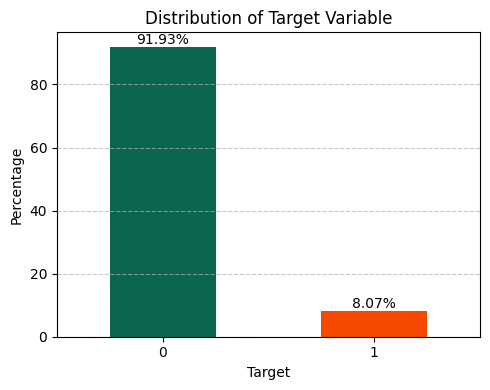

In [13]:
target_distribution = df_application_train['TARGET'].value_counts(normalize=True) * 100

plt.figure(figsize=(5, 4))
ax = target_distribution.plot(kind='bar', color=[neg_color, pos_color])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(target_distribution):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

### Insights

From the initial exploration of the dataset, several key insights emerge:
- **Missing Values**: The dataset contains 67 columns with missing values, indicating the need for data imputation or handling missing values during preprocessing.
- **Data Types**: Among the columns, approximately 69 are numeric, while 51 are categorical, providing a varied mix of data types for analysis.
- **Target Distribution**: The target variable exhibits class imbalance, with the positive class representing about 8% of the total observations. This imbalance may require special attention during model training to prevent biased predictions.

---


### Feature Exploration

We will explore the dataset's features to identify the most influential ones using correlation analysis for numerical features and chi-squared analysis for categorical features. Subsequently, we will visualize these features in relation to the target variable.

Starting with numerical features:

In [5]:
corr_matrix = df_application_train[numerical_columns+['TARGET']].corr(numeric_only=True)
corr_matrix_abs = corr_matrix['TARGET'].abs().sort_values(ascending=False)
corr_matrix_abs

TARGET                        1.000000
EXT_SOURCE_3                  0.178919
EXT_SOURCE_2                  0.160472
EXT_SOURCE_1                  0.155317
DAYS_BIRTH                    0.078239
                                ...   
NONLIVINGAPARTMENTS_MEDI      0.002757
AMT_REQ_CREDIT_BUREAU_DAY     0.002704
AMT_REQ_CREDIT_BUREAU_QRT     0.002022
NONLIVINGAPARTMENTS_MODE      0.001557
AMT_REQ_CREDIT_BUREAU_WEEK    0.000788
Name: TARGET, Length: 70, dtype: float64

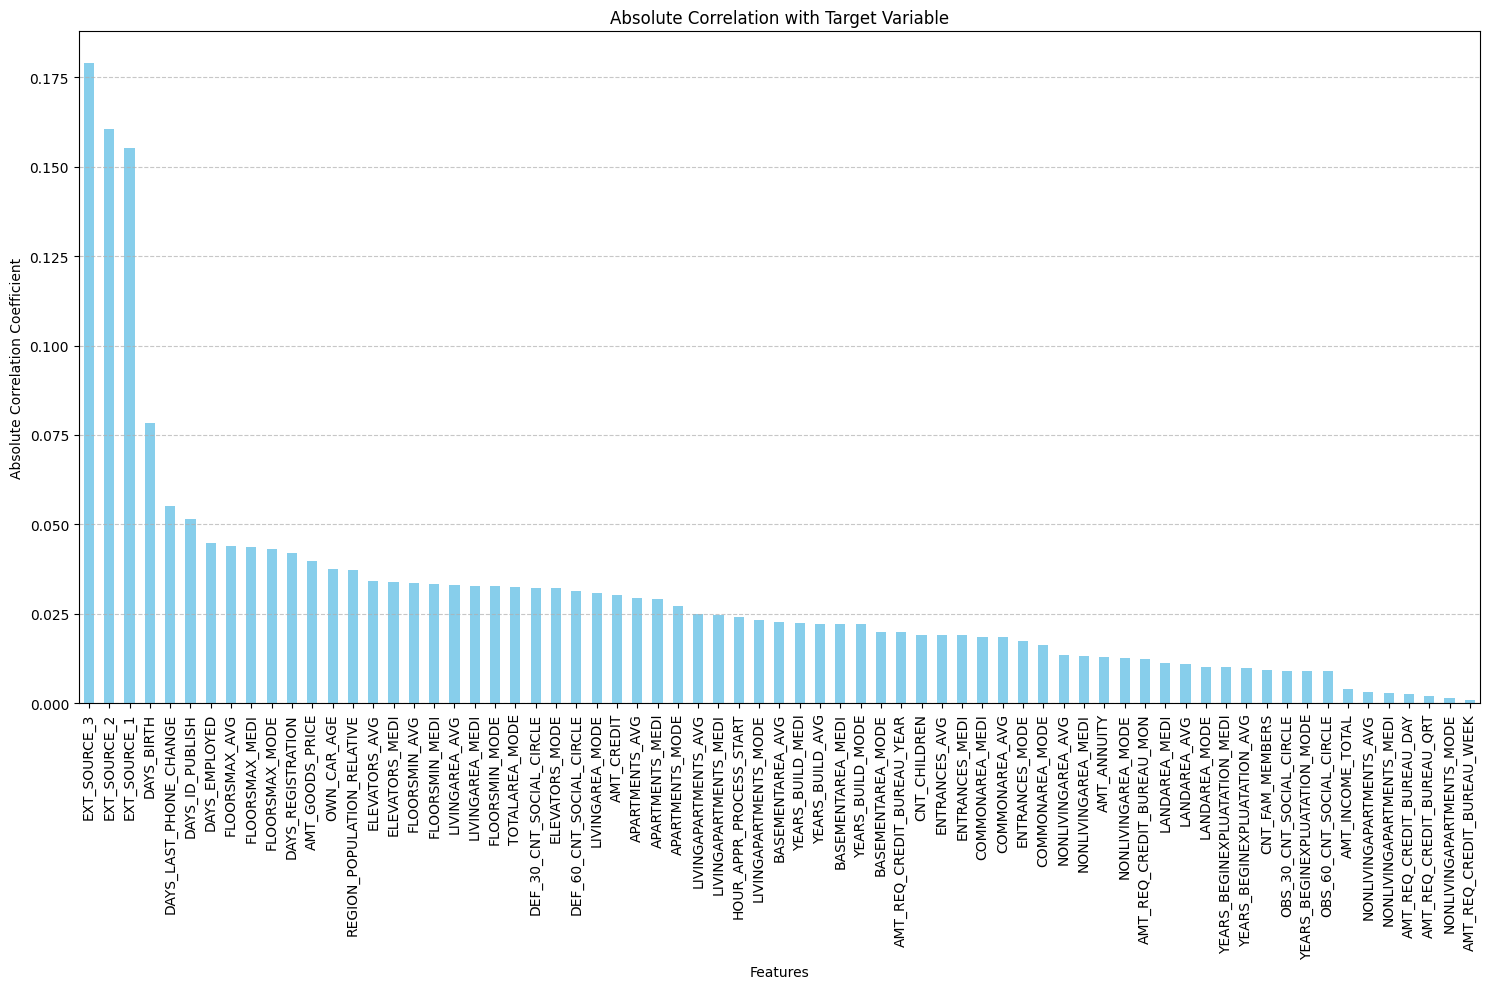

In [161]:
plt.figure(figsize=(15, 10))
corr_matrix_abs[1:].plot(kind='bar', color='skyblue')
plt.title('Absolute Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

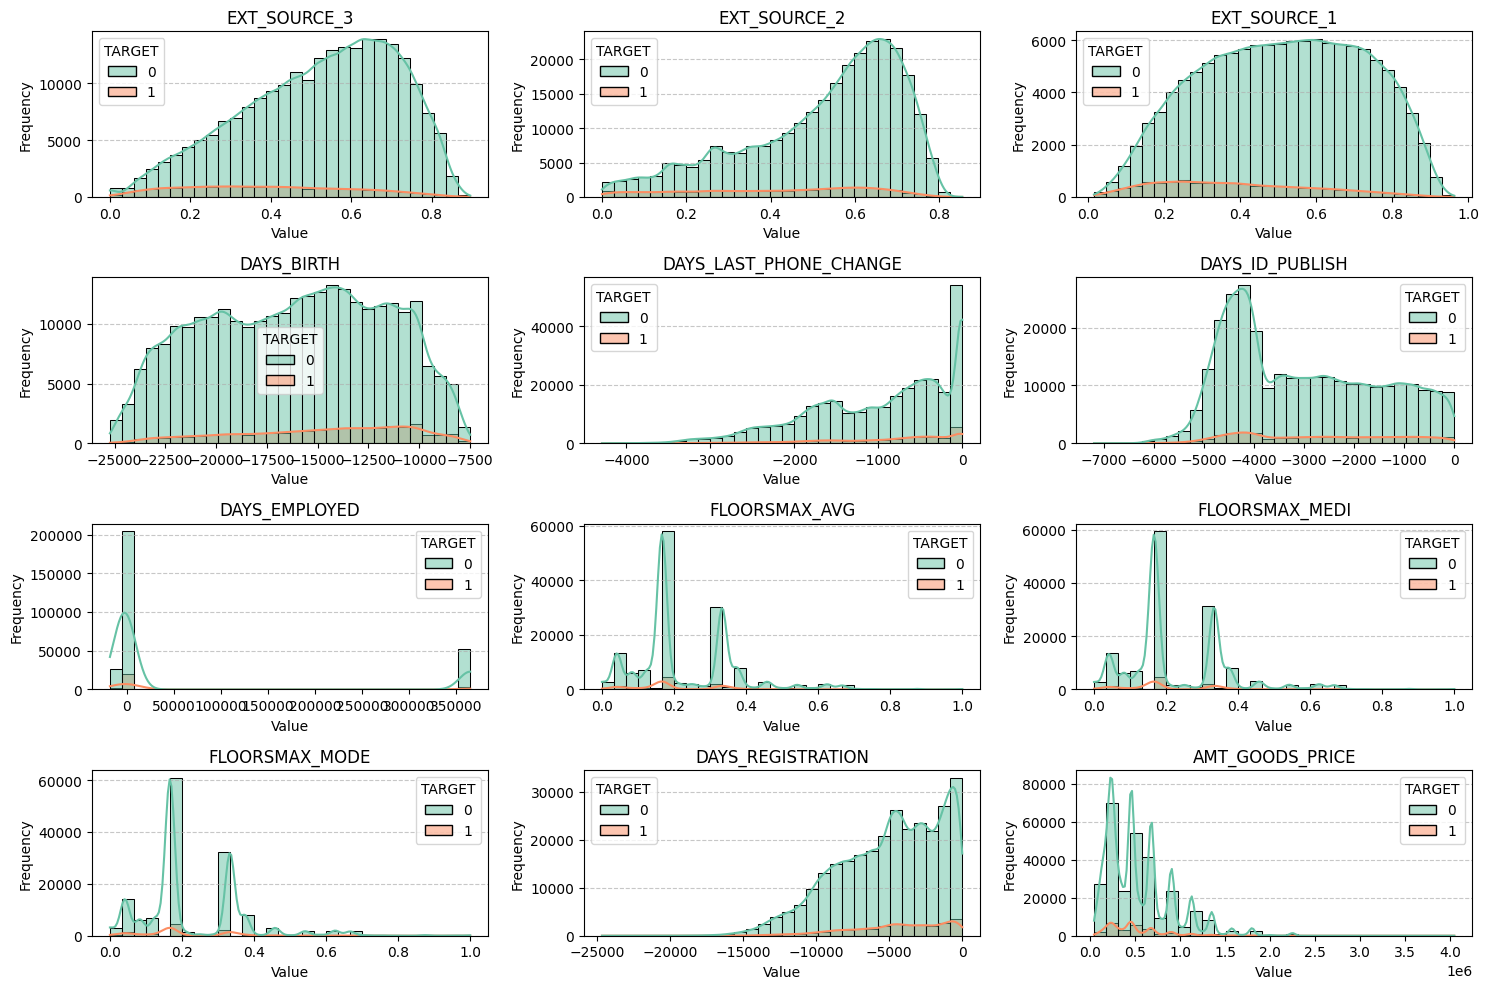

In [11]:
plot_numerical_distribution(
    df_application_train, 
    corr_matrix_abs.index[1:13], 
    target_column='TARGET', 
    kde=True, 
    color=[pos_color, neg_color])

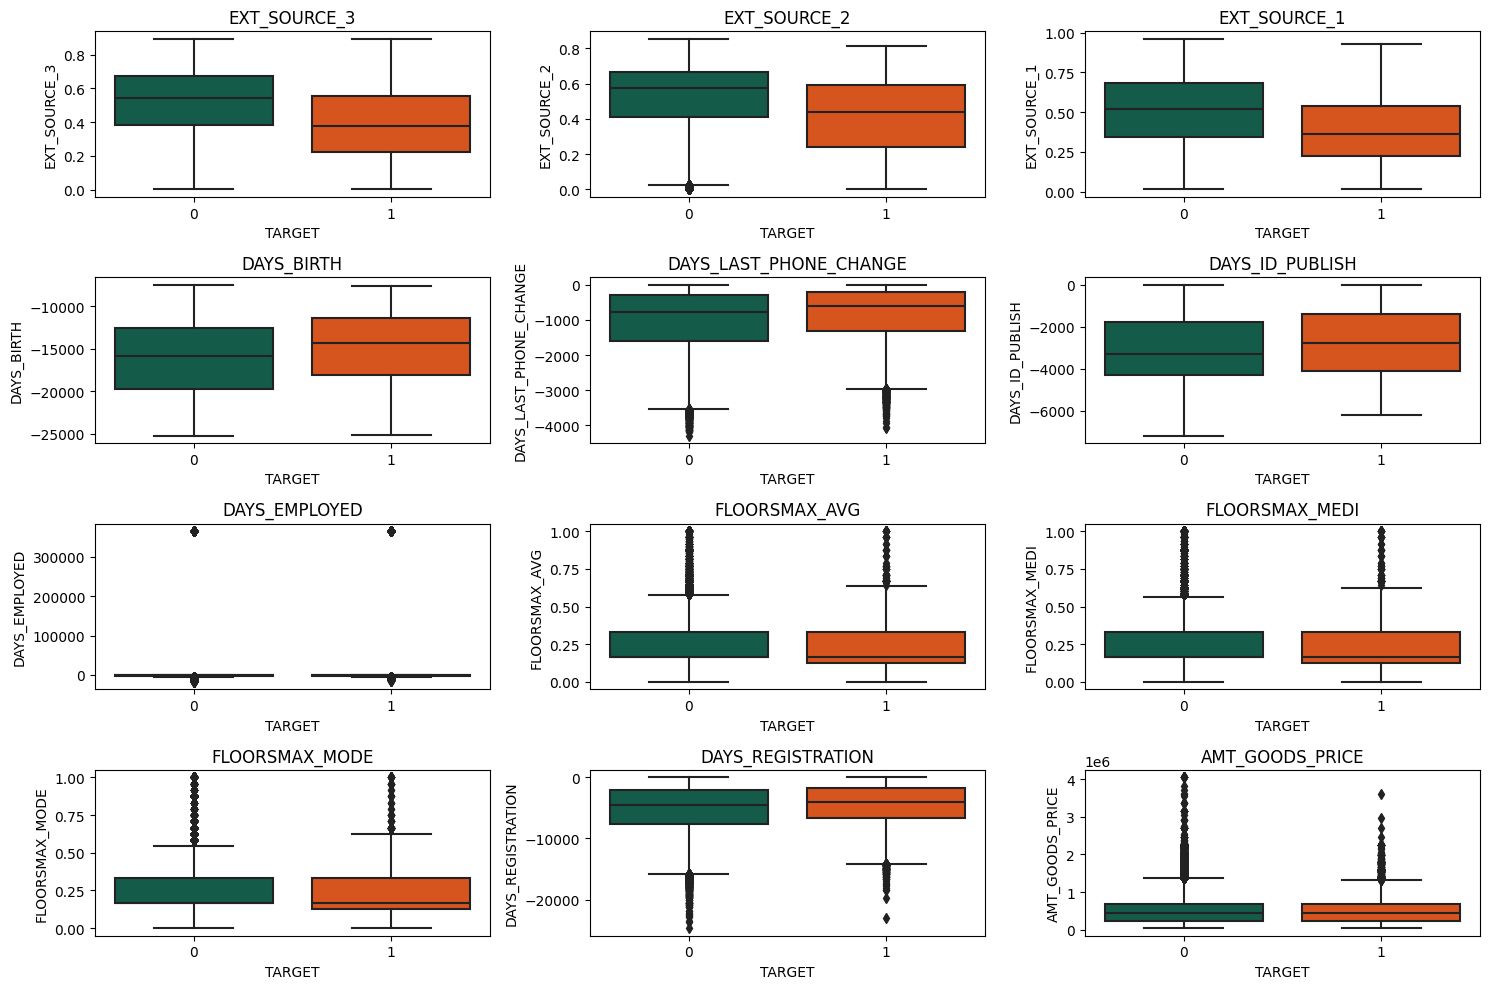

In [10]:
plot_boxplots(df_application_train,  corr_matrix_abs.index[1:13], 'TARGET' , pos_color, neg_color)

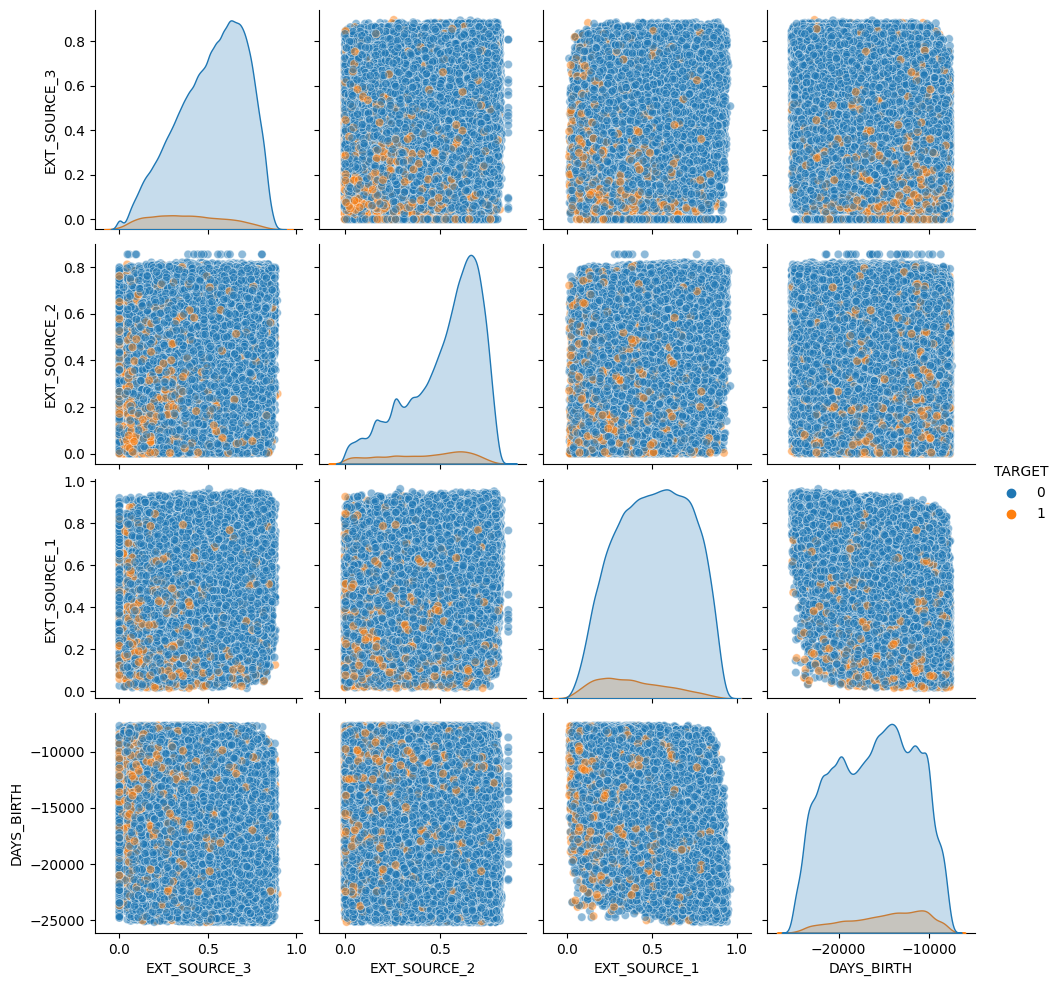

In [185]:
sns.pairplot(df_application_train[corr_matrix_abs.index[:5]], hue="TARGET", plot_kws={'alpha':0.5})
plt.show()

In [6]:

relationship_results = quantify_chi2_target(df_application_train, categorical_columns, 'TARGET').sort_values('Chi-square', ascending=False)
sorted_cat_features = relationship_results['Feature'].to_list()

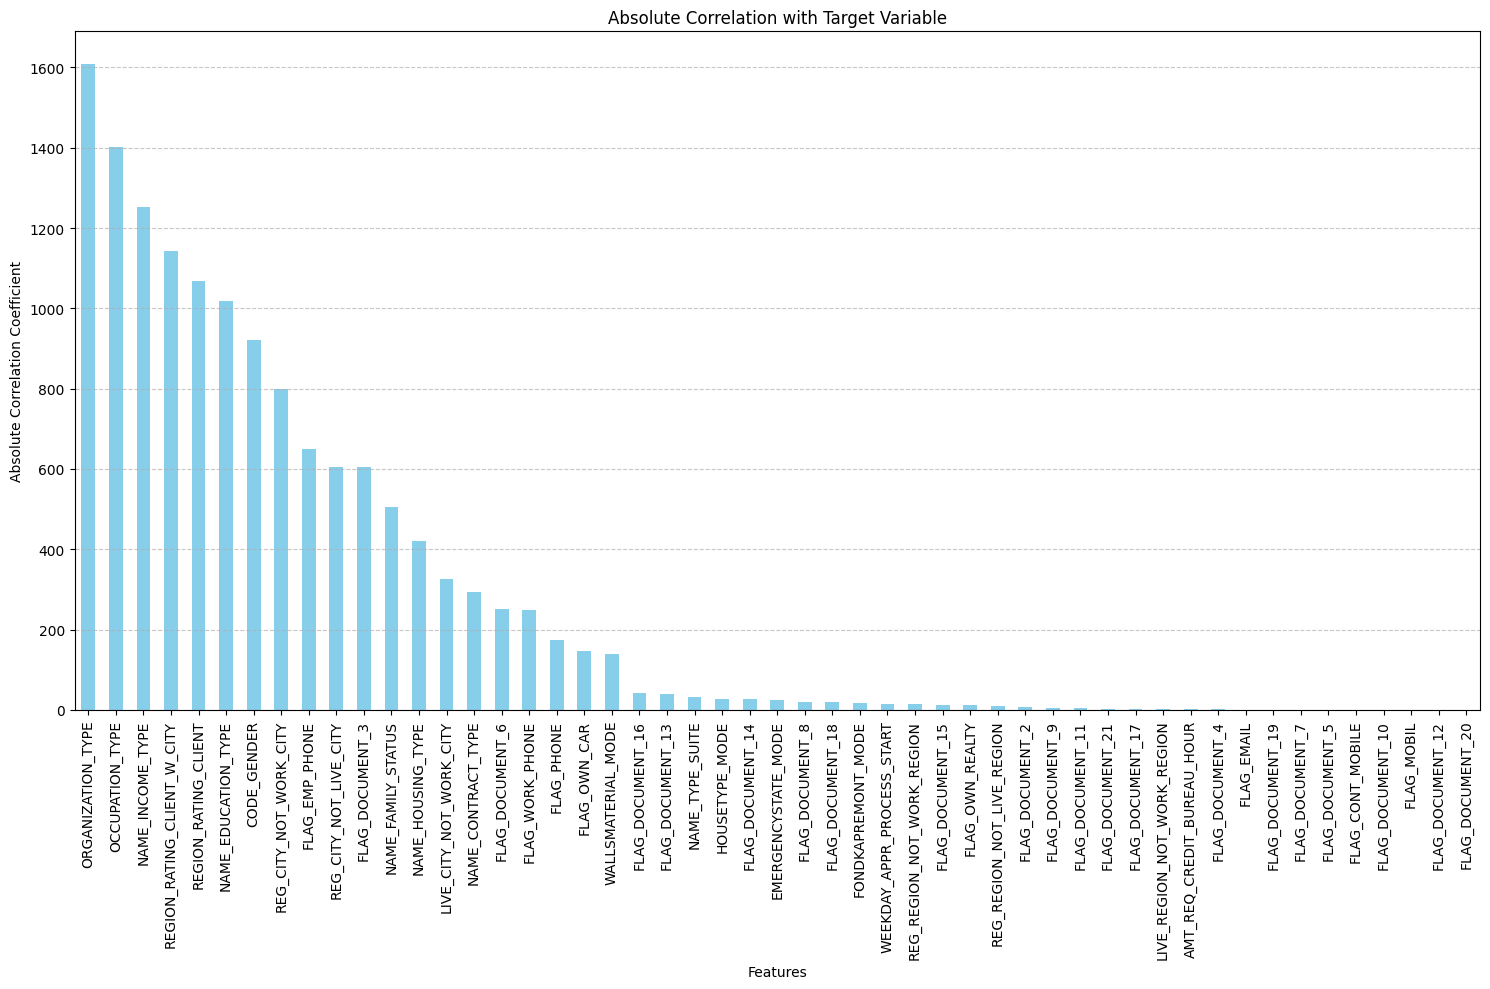

In [7]:
fig = plt.figure(figsize=(15, 10))
relationship_results['Chi-square'].plot(kind='bar', color='skyblue')
plt.title('Absolute Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(ticks=range(len(sorted_cat_features)), labels=sorted_cat_features, rotation=90)  # Set tick labels using 'important'
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


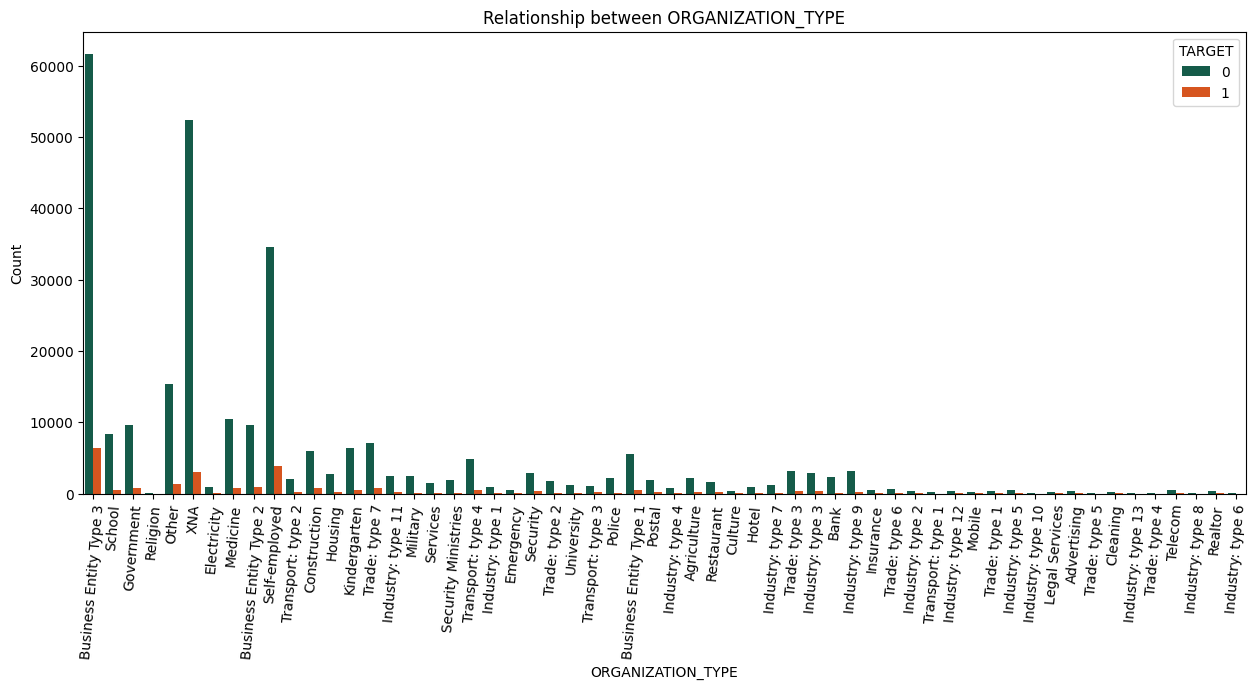

In [8]:
plt.figure(figsize=(15, 6))
sns.countplot(x=sorted_cat_features[0], hue='TARGET', data=df_application_train, palette=[neg_color, pos_color])
plt.title(f'Relationship between {sorted_cat_features[0]}')
plt.xlabel(sorted_cat_features[0])
plt.ylabel('Count')
plt.legend(title='TARGET')
plt.xticks(rotation=85)
plt.show()

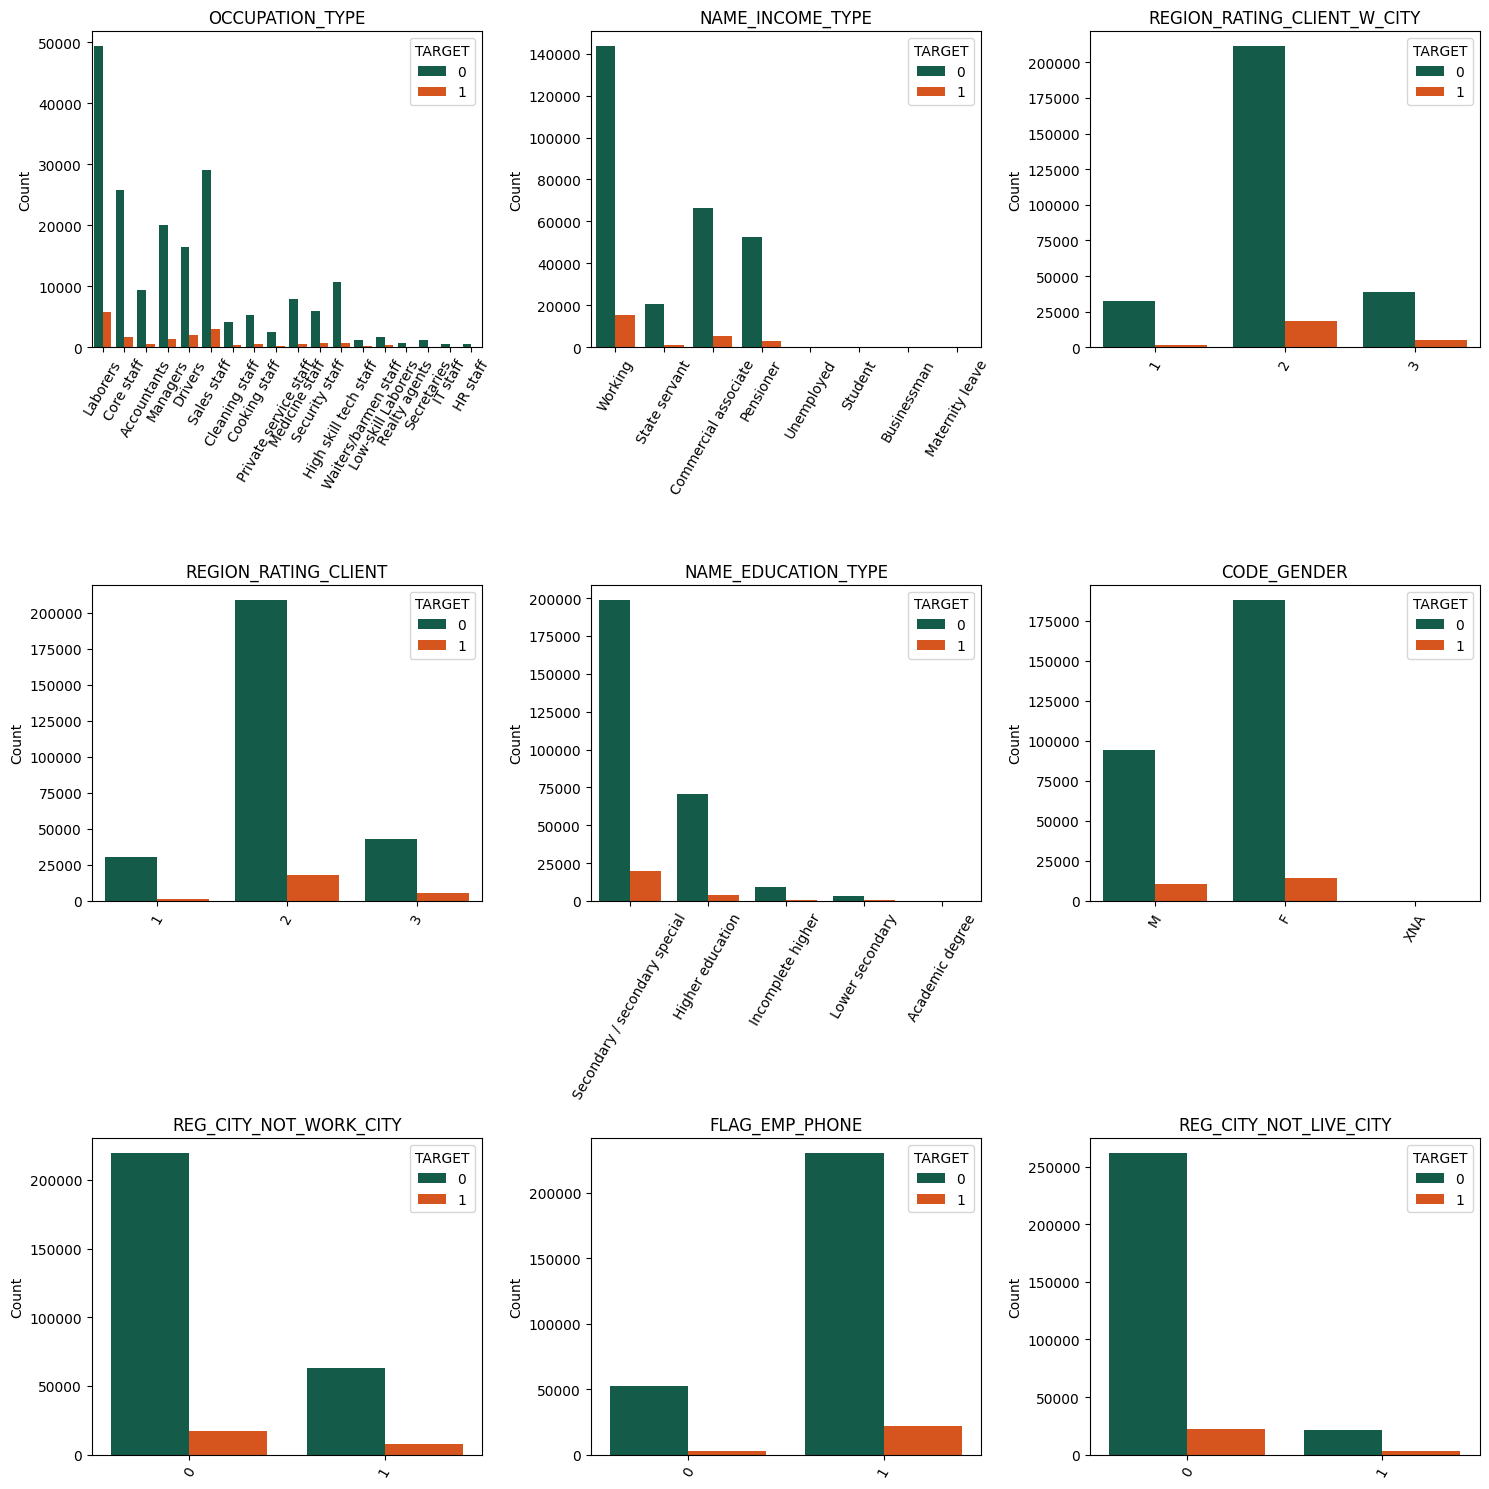

In [9]:
plot_categorical_variables(df_application_train, sorted_cat_features[1:10], 'TARGET', color = [neg_color, pos_color])

# 4. Feature Engeneering

In [184]:
df_bureau = pd.read_csv('data/tables/bureau.csv')
df_bureau_balance =pd.read_csv('data/tables/bureau_balance.csv')

In [77]:
print(df_bureau.shape)
print(df_bureau.nunique())
df_bureau.head()

(1716428, 17)
SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
print_description('bureau.csv', 'data/tables/HomeCredit_columns_description.csv')

SK_ID_CURR: ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 
SK_BUREAU_ID: Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits
CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit
DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit
CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample
DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit
DAYS_ENDDATE_FACT: Days since CB credit ended at the time of application in Home Credit (only for closed credit)
AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
CNT_CREDIT_PROLONG: How many times was the Credit Bureau credit prolon

In [76]:
print(df_bureau_balance.shape)
print(df_bureau_balance.nunique())
df_bureau_balance.head()

(27299925, 3)
SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [70]:
for row,des in df_description[df_description.Table == 'bureau_balance.csv'][[ 'Row', 'Description']].iterrows():
    print( des.Row,':',des.Description)

SK_BUREAU_ID : Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table 
MONTHS_BALANCE : Month of balance relative to application date (-1 means the freshest balance date)
STATUS : Status of Credit Bureau loan during the month (active, closed, DPD0-30,� [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,� 5 means DPD 120+ or sold or written off ] )


In [85]:
new_features = df_bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',
    'DAYS_CREDIT': 'mean',
    'CREDIT_DAY_OVERDUE': 'max',
    'DAYS_CREDIT_ENDDATE': 'mean',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'CREDIT_TYPE': 'nunique',  # Count unique types of credits
    'AMT_ANNUITY': 'mean'
}).reset_index()

In [87]:
new_features.shape

(305811, 9)

In [89]:
a = pd.merge(df_application_train[['SK_ID_CURR', 'TARGET']], new_features, on='SK_ID_CURR', how= 'left')

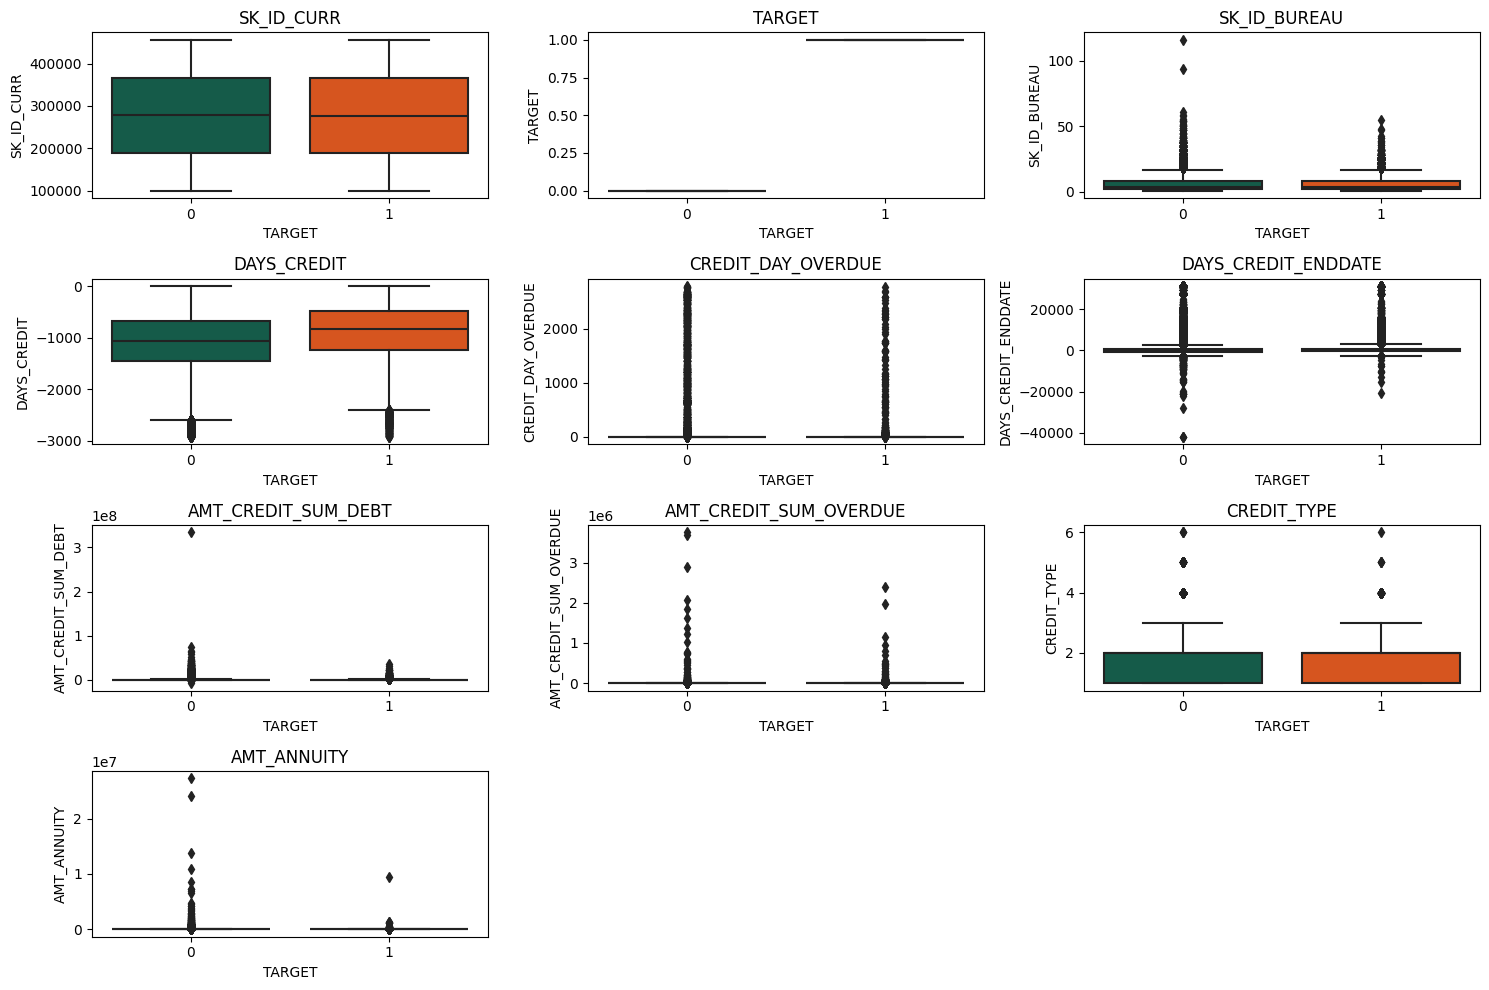

In [91]:
plot_boxplots(a,a.columns, 'TARGET', pos_color, neg_color)

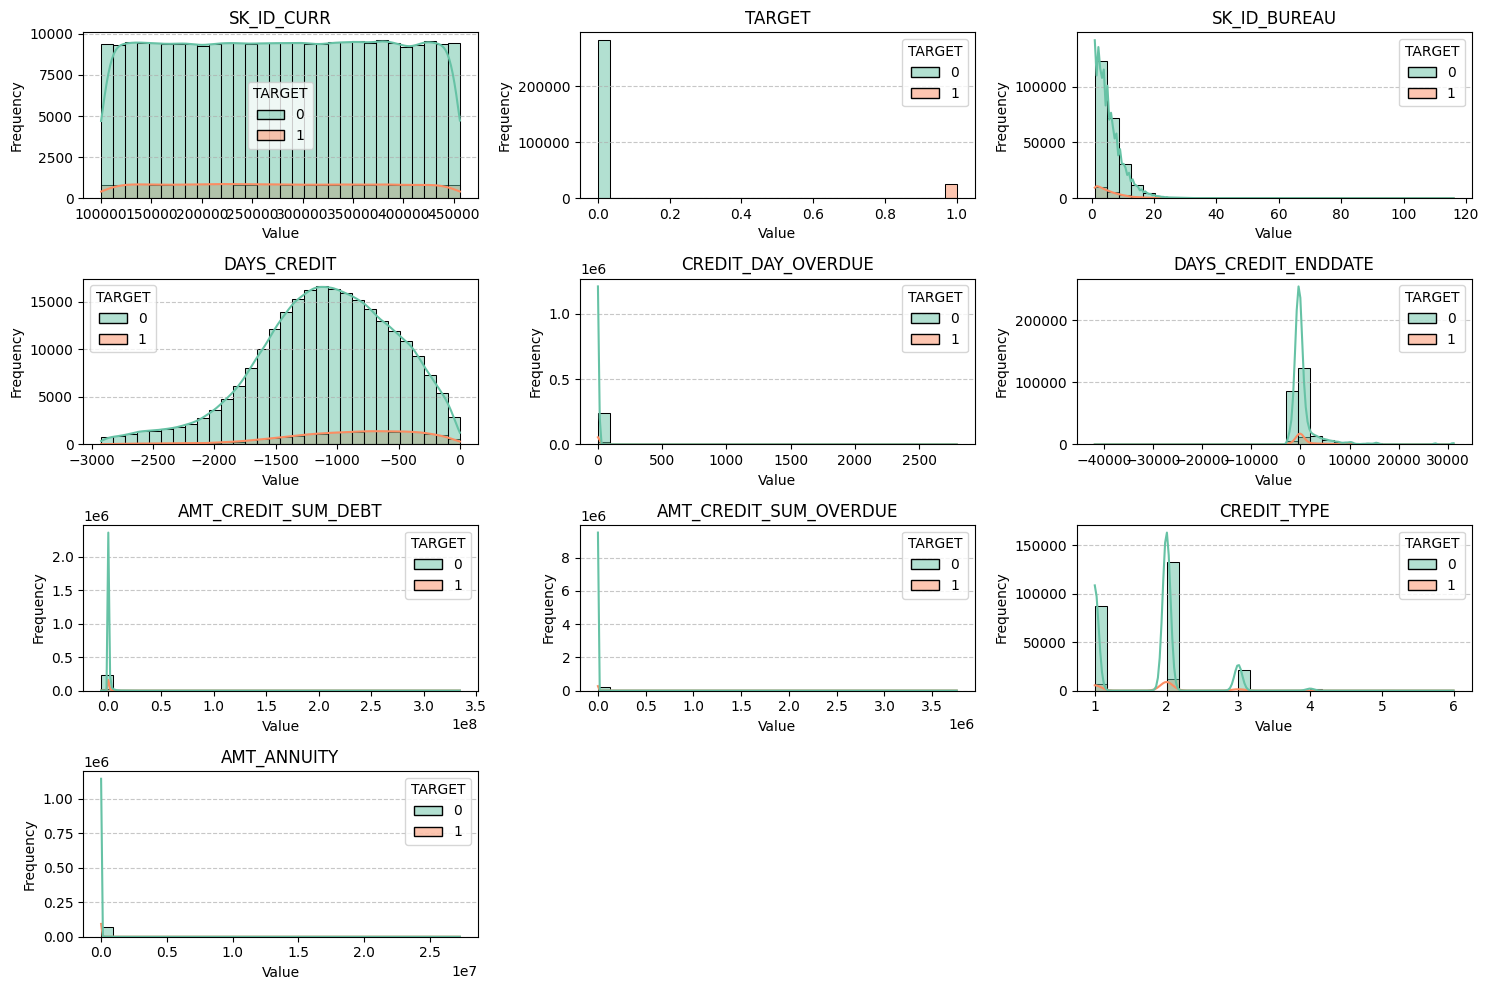

In [92]:
plot_numerical_distribution(a, a.columns, 'TARGET')

In [93]:
corr_matrix = a.corr(numeric_only=True)
corr_matrix_abs = corr_matrix['TARGET'].abs().sort_values(ascending=False)
corr_matrix_abs

TARGET                    1.000000
DAYS_CREDIT               0.089729
DAYS_CREDIT_ENDDATE       0.046983
AMT_CREDIT_SUM_OVERDUE    0.013335
AMT_CREDIT_SUM_DEBT       0.007144
CREDIT_DAY_OVERDUE        0.005493
CREDIT_TYPE               0.004624
SK_ID_BUREAU              0.004056
SK_ID_CURR                0.002108
AMT_ANNUITY               0.001391
Name: TARGET, dtype: float64